# Clasificación Multiclase del dataset FashionMNIST  
El objetivo de este cuadernillo es clasificar datos de entrada en diferentes categorías. En el caso específico de clasificar el conjunto de datos FashionMNIST, se trata de un conjunto de imágenes en escala de grises de 28x28 píxeles que representan prendas de vestir en 10 categorías distintas.

0  T-shirt/top (Camiseta/top)
1  Trouser (Pantalón)
2  Pullover (Jersey)
3  Dress (Vestido)
4  Coat (Abrigo)
5  Sandal (Sandalia)
6  Shirt (Camisa)
7  Sneaker (Zapatilla deportiva)
8  Bag (Bolso)
9  Ankle boot (Bota de tobillo)

In [22]:
# utilizado para manipular rutas y directorios
import os

# Computación cientifica y vectorial para Python
import numpy as np

# Libreria para gráficos
from matplotlib import pyplot

# Modulo de optimización
from scipy import optimize

# Modulo para cargar archivos de datos en formato MATLAB
from scipy.io import loadmat

# llama a matplotlib para embeber graficos en el cuadernillo
%matplotlib inline

## Visualizar los datos

In [23]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

In [24]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

## Dataset
Se carga el dataset del google drive, el cual consta de dos archivos csv, uno para entrenamiento y otro para el test. El dataset consta de 70000 imagenes:


*   60000 para entrenamiento
*   10000 para test



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
data = np.loadtxt('/content/drive/MyDrive/Datasets/fashion-mnist_train.csv', delimiter=",", skiprows=1)
print(data)

[[2. 0. 0. ... 0. 0. 0.]
 [9. 0. 0. ... 0. 0. 0.]
 [6. 0. 0. ... 0. 0. 0.]
 ...
 [8. 0. 0. ... 0. 0. 0.]
 [8. 0. 0. ... 0. 0. 0.]
 [7. 0. 0. ... 0. 0. 0.]]


In [27]:
X, y = data[:, 1:], data[:, 0]
X.shape, y.shape

((60000, 784), (60000,))

In [28]:
data_test = np.loadtxt('/content/drive/MyDrive/Datasets/fashion-mnist_test.csv', delimiter=",", skiprows=1)
print(data_test)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [8. 0. 0. ... 0. 1. 0.]
 [8. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [29]:
X_test, y_test = data_test[:, 1:], data_test[:, 0]
X_test.shape, y_test.shape

((10000, 784), (10000,))

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   4.   0.   0.   0.   0.   0.  62.  61.  21.  29.
  23.  51. 136.  61.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  88. 201. 228. 225. 255. 115.  62.
 137. 255. 235. 222. 255. 135.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.  47. 252. 234. 238. 224. 215. 215. 229. 108.
 180. 207. 214. 224. 231. 249. 254.  45.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   0.   0. 214. 222. 210. 213. 224. 225. 217. 220. 254.
 233. 219. 221. 217. 223. 221. 240. 254.   0.   0.   1.   0.   0.   0.
   1. 

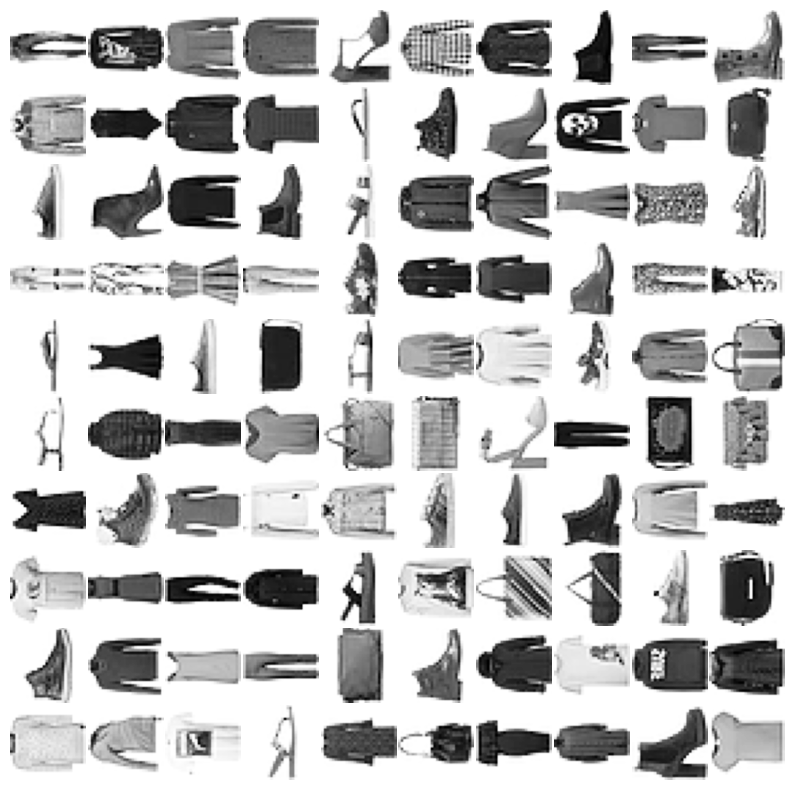

In [30]:
print(X[0])
print(y[0])

m = y.size

# Randomicamente selecciona 100 puntos de datos para visualizar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

### Funciones de activación

Para la capa oculta de nuestro MLP utilizaremos una función de activación de tipo `relu`, de la cual necesitaremos su derivada.

In [31]:
def relu(x):
  return np.maximum(0, x)

def reluPrime(x):
  return x > 0

En cuanto a las funciones de activación que utilizaremos a la salida del MLP, éstas son las que hemos introducido en posts anteriores:

- Lineal: usada para regresión (junto a la función de pérdida MSE).
- Sigmoid: usada para clasificación binaria (junto a la función de pérdida BCE).
- Softmax: usada para clasificación multiclase (junto a la función de pérdida crossentropy, CE).

In [32]:
def linear(x):
    return x

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

### Funciones de pérdida

Como acabamos de comentar en la sección anterior, estas son las funciones de pérdida que hemos visto hasta ahora para las diferentes tareas.

In [33]:
# Mean Square Error -> usada para regresión (con activación lineal)
def mse(y, y_hat):
    return np.mean((y_hat - y.reshape(y_hat.shape))**2)

# Binary Cross Entropy -> usada para clasificación binaria (con sigmoid)
def bce(y, y_hat):
    return - np.mean(y.reshape(y_hat.shape)*np.log(y_hat) - (1 - y.reshape(y_hat.shape))*np.log(1 - y_hat))

# Cross Entropy (aplica softmax + cross entropy de manera estable) -> usada para clasificación multiclase
def crossentropy(y, y_hat):
    logits = y_hat[np.arange(len(y_hat)),y]
    entropy = - logits + np.log(np.sum(np.exp(y_hat),axis=-1))
    return entropy.mean()

Y sus derivadas

In [34]:
def grad_mse(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_bce(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_crossentropy(y, y_hat):
    answers = np.zeros_like(y_hat)
    answers[np.arange(len(y_hat)),y] = 1
    return (- answers + softmax(y_hat)) / y_hat.shape[0]

### Implementación MLP

Ahora que ya tenemos definidas las diferentes funciones de activación y de pérdida que necesitamos, vamos a implementar nuestro MLP de dos capas capaz de llevar a cabo tanto tareas de regresión como de clasificación. Del mismo modo que ya hicimos con el `Perceptrón`, definiremos una clase base que servirá para la implementación de las clases particulares para cada caso.

In [35]:
# clase base MLP -> capa de perceptrones

class MLP():
  def __init__(self, D_in, H, D_out, loss, grad_loss, activation):
    # pesos de la capa 1
    self.w1, self.b1 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(D_in+H)),
                                  size=(D_in, H)), np.zeros(H)
    # pesos de la capa 2
    self.w2, self.b2 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(H+D_out)),
                                  size=(H, D_out)), np.zeros(D_out)
    self.ws = []
    # función de pérdida y derivada
    self.loss = loss
    self.grad_loss = grad_loss
    # función de activación
    self.activation = activation

  def __call__(self, x):
    # salida de la capa 1
    self.h_pre = np.dot(x, self.w1) + self.b1
    self.h = relu(self.h_pre)
    # salida del MLP
    y_hat = np.dot(self.h, self.w2) + self.b2
    return self.activation(y_hat)

  def fit(self, X, Y, epochs = 100, lr = 0.001, batch_size=None, verbose=True, log_each=1):
    batch_size = len(X) if batch_size == None else batch_size
    batches = len(X) // batch_size
    l = []
    for e in range(1,epochs+1):
        # Mini-Batch Gradient Descent
        _l = []
        for b in range(batches):
            # batch de datos
            x = X[b*batch_size:(b+1)*batch_size]
            y = Y[b*batch_size:(b+1)*batch_size]
            # salida del perceptrón
            y_pred = self(x)
            # función de pérdida
            loss = self.loss(y, y_pred)
            _l.append(loss)
            # Backprop
            dldy = self.grad_loss(y, y_pred)
            grad_w2 = np.dot(self.h.T, dldy)
            grad_b2 = dldy.mean(axis=0)
            dldh = np.dot(dldy, self.w2.T)*reluPrime(self.h_pre)
            grad_w1 = np.dot(x.T, dldh)
            grad_b1 = dldh.mean(axis=0)
            # Update (GD)
            self.w1 = self.w1 - lr * grad_w1
            self.b1 = self.b1 - lr * grad_b1
            self.w2 = self.w2 - lr * grad_w2
            self.b2 = self.b2 - lr * grad_b2
        l.append(np.mean(_l))
        # guardamos pesos intermedios para visualización
        self.ws.append((
            self.w1.copy(),
            self.b1.copy(),
            self.w2.copy(),
            self.b2.copy()
        ))
        if verbose and not e % log_each:
            print(f'Epoch: {e}/{epochs}, Loss: {np.mean(l):.5f}')

  def predict(self, ws, x):
    w1, b1, w2, b2 = ws
    h = relu(np.dot(x, w1) + b1)
    y_hat = np.dot(h, w2) + b2
    return self.activation(y_hat)

In [36]:
# MLP para regresión
class MLPRegression(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, mse, grad_mse, linear)

# MLP para clasificación binaria
class MLPBinaryClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, bce, grad_bce, sigmoid)

# MLP para clasificación multiclase
class MLPClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, crossentropy, grad_crossentropy, linear)

In [37]:
# Normalizacion de los datos
# X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = X / 255

In [38]:
print(type(y))

<class 'numpy.ndarray'>


In [39]:
model = MLPClassification(D_in=784, H=100, D_out=10)
epochs, lr = 400, 0.1
y = y.astype(int)
model.fit(X_norm, y, epochs, lr, batch_size=10, log_each=10)

Epoch: 10/400, Loss: 0.35120
Epoch: 20/400, Loss: 0.29893
Epoch: 30/400, Loss: 0.26794
Epoch: 40/400, Loss: 0.24608
Epoch: 50/400, Loss: 0.22895
Epoch: 60/400, Loss: 0.21523
Epoch: 70/400, Loss: 0.20363
Epoch: 80/400, Loss: 0.19383
Epoch: 90/400, Loss: 0.18525
Epoch: 100/400, Loss: 0.17766
Epoch: 110/400, Loss: 0.17093
Epoch: 120/400, Loss: 0.16501
Epoch: 130/400, Loss: 0.15952
Epoch: 140/400, Loss: 0.15448
Epoch: 150/400, Loss: 0.14981
Epoch: 160/400, Loss: 0.14544
Epoch: 170/400, Loss: 0.14146
Epoch: 180/400, Loss: 0.13782
Epoch: 190/400, Loss: 0.13439
Epoch: 200/400, Loss: 0.13110
Epoch: 210/400, Loss: 0.12823
Epoch: 220/400, Loss: 0.12526
Epoch: 230/400, Loss: 0.12264
Epoch: 240/400, Loss: 0.12004
Epoch: 250/400, Loss: 0.11760
Epoch: 260/400, Loss: 0.11521
Epoch: 270/400, Loss: 0.11300
Epoch: 280/400, Loss: 0.11087
Epoch: 290/400, Loss: 0.10892
Epoch: 300/400, Loss: 0.10700
Epoch: 310/400, Loss: 0.10520
Epoch: 320/400, Loss: 0.10346
Epoch: 330/400, Loss: 0.10183
Epoch: 340/400, Los

Con 400 epochs llegamos a un error del 9,187%

In [40]:
def mlp_prediction(model, x):
    w1, b1, w2, b2 = model.ws[-1]  # Últimos pesos guardados del modelo entrenado
    h = relu(np.dot(x, w1) + b1)
    y_hat = np.dot(h, w2) + b2
    return model.activation(y_hat)

In [41]:
Theta1, b1, Theta2, b2 = model.ws[-1]
Theta1.shape, b1.shape, Theta2.shape, b2.shape

((784, 100), (100,), (100, 10), (10,))

In [42]:
prediction = model.predict(model.ws[-1], X_test)
prediction[0]

array([13884.39616187,  -923.56732718, -5607.80963395, -1248.82273955,
        3457.33184688,  -382.0647538 , 11509.01145552, -9478.44283154,
       -1889.91755872, -9582.80066088])